# Creation of a Staged Tree

## EventTree Class

The first starting point in constructing a Chain Event Graph (CEG) is to create 
an *event tree* describing the process being studies. An event tree is a directed 
tree graph with a single root node. The nodes with no emanating edges are
called *leaves*, and the non-leaf nodes are called *situations*. 

In this example we work with a data set which contains 4 catagorical variables; `Classification`, `Group`, `Difficulty`, `Response`.

Each individual is given a binary classification; $\text{`Blast'}$ or $\text{`Non-blast'}$. Each group is rated on their experience level: $\text{`Experienced'}$ $\text{`Inexperienced'}$, or $\text{`Novice'}$. The classification task they are given has a difficulty rating of $\text{`Easy'}$ or $\text{`Hard'}$. Finally, their response is shown: $\text{`Blast'}$ or $\text{`Non-blast'}$.

We begin by importing the data set and initializing the `EventTree` object, as shown below:

In [87]:
from cegpy import EventTree
import pandas as pd

df = pd.read_excel('../../data/medical_dm_modified.xlsx')
print(df.head())

#initialize the event tree
et = EventTree(df)

  Classification        Group Difficulty   Response
0          Blast  Experienced       Easy      Blast
1      Non-blast  Experienced       Easy  Non-blast
2      Non-blast  Experienced       Hard      Blast
3      Non-blast  Experienced       Hard  Non-blast
4          Blast  Experienced       Easy      Blast


To initi

In order to display the EventTree, we can use the method `create_figure()`. The numbers above the edges of the event tree represent the number of indiviuals who passed through the given edge. 

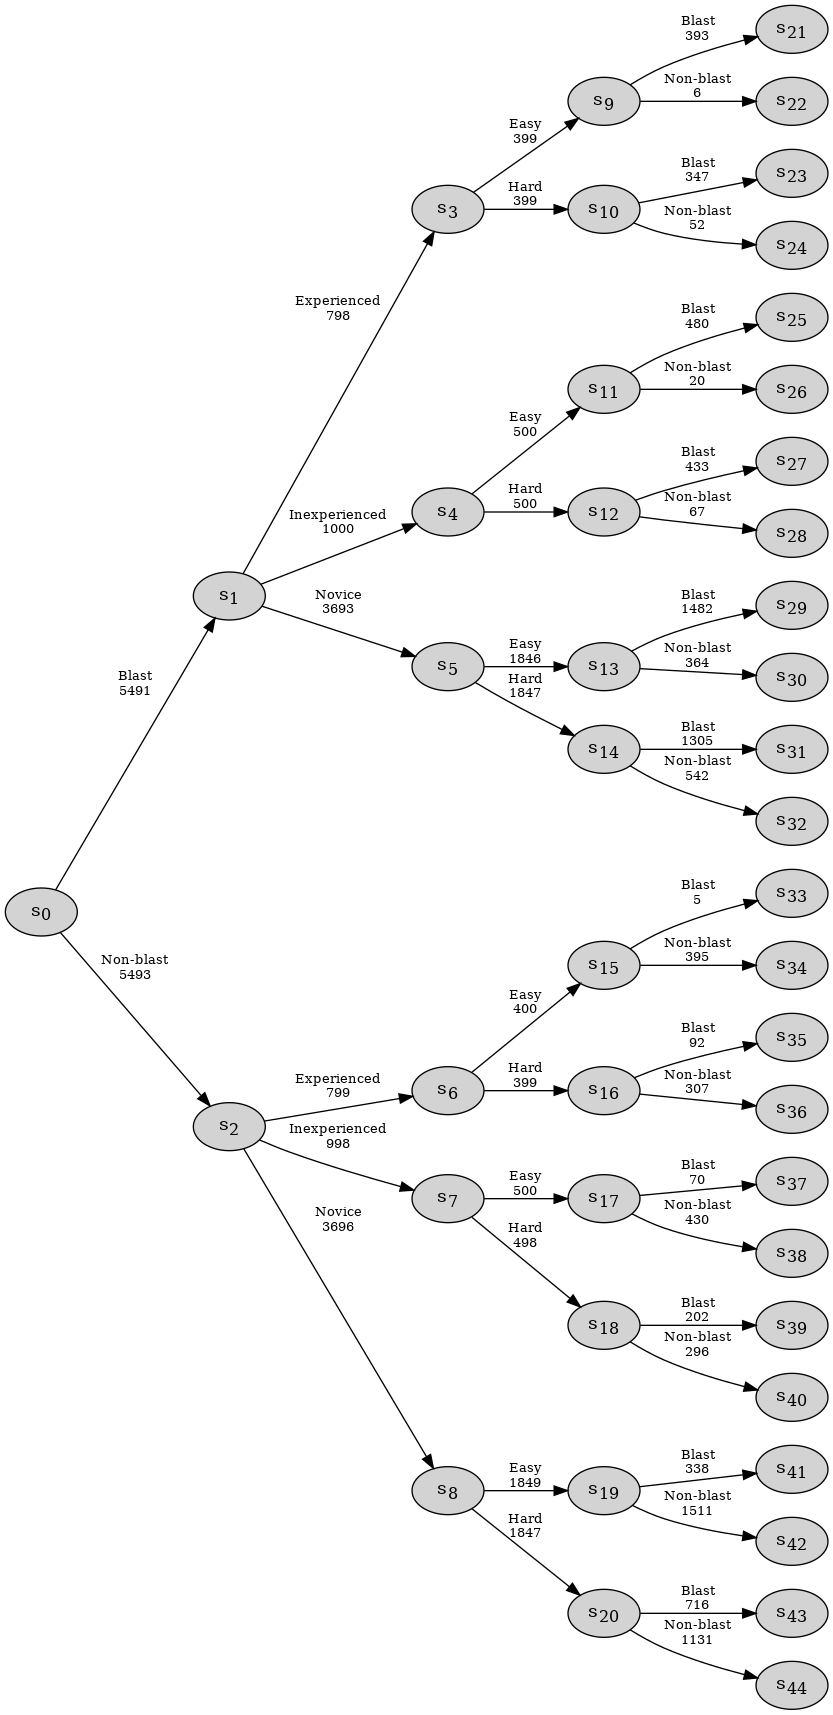

In [2]:
et.create_figure()

## StagedTree Class

In an event tree, each situation is associated with a transition parameter vector which indicates the conditional
probability of an individual, who has arrived at the situation, going along one of its edges. In order to create a CEG, we first need to elict a *staged tree*. 
This is done by first partitioning situations into *stages*, which are collection of situation in the event tree whose immediate evolutions, i.e. their
associated conditional transition parameter vectors, are equivalent. To indicate this symmetry, all situations in the same stage are assinged a single colour.

Identification of the stages in the event tree can be done using any suitable model selection algorithm. Currently, the only avaible selection algoirhtm in `cegpy` is the *agglomerative hierarchical clustering (AHC)* algorithm [(Freeman and Smith, 2011)](https://warwick.ac.uk/fac/sci/statistics/research/graphicalbayes/bayesian_map_model_selection_of_chain_event_graphs.pdf).

In order to creat a staged tree in `cegpy` we first initialize a `StagedTree` object from the dataset and then run th AHC algorithm using the `create_AHC_tarnsitions` method, as displayed below. The output of the AHC algorithm is a dictionary containing the following information:
- `Merged Situations` - a list of tuples representing the partition of the nodes into stages
- `Log Likelihood` - the log likelihood of the data under the model selected by AHC

In [3]:
from cegpy import StagedTree

st = StagedTree(df)
st.calculate_AHC_transitions()

{'Merged Situations': [('s1', 's2'),
  ('s20', 's18'),
  ('s10', 's12'),
  ('s3', 's6', 's4', 's5', 's7', 's8'),
  ('s9', 's11'),
  ('s19', 's17', 's16'),
  ('s0',),
  ('s13',),
  ('s14',),
  ('s15',)],
 'Log Likelihood': -30091.353114865367}

Within `cegpy`, singleton stages, i.e. stages contatining a single situation, are coloured white, leaves and their corresponding sink node are coloured in light-grey. Runing AHC on our data set results in the following staged tree.

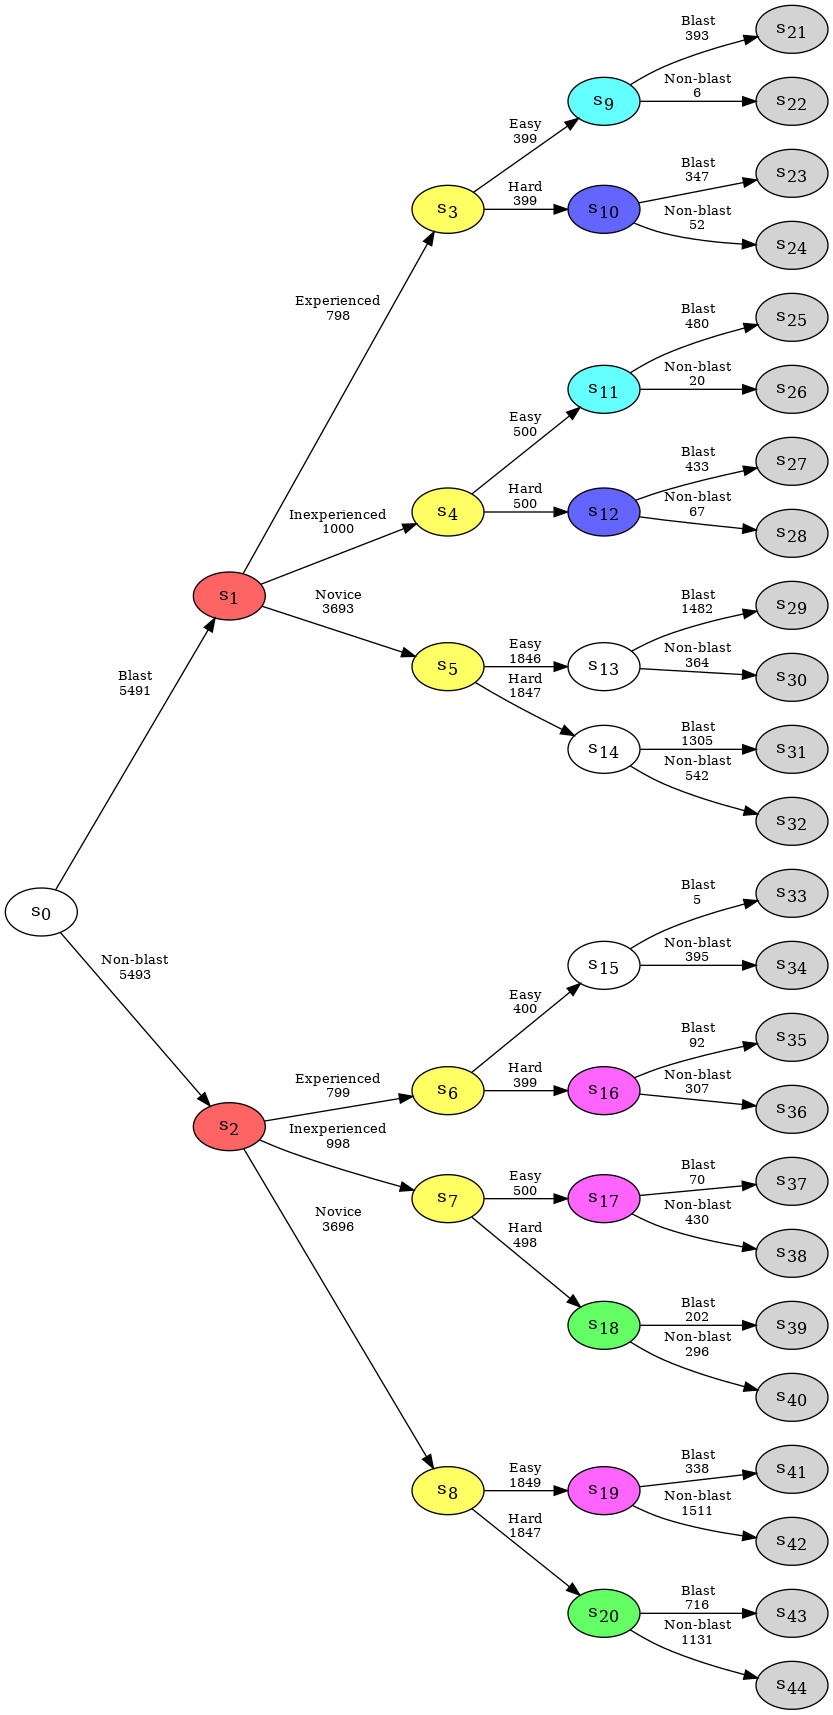

In [4]:
st.create_figure()

### Custom Hyperstages

`cegpy` allows the user to specify which situations are allowed to be merged by the AHC algorithm. This is done by specifying a *hyperstage* [(Collazo et al., 2017)](http://wrap.warwick.ac.uk/91075/1/WRAP_Theses_Collazo_2017.pdf) which is a collection of sets such that two situations cannot be in the same stage unless they belong to the same set in the hyperstage. Under a default setting in `cegpy`, all situations which have the same number of outgoing edges and equivalent set of edge labels are in the same set within the hyperstage. The defualt hyperstages of a given tree can be displayed by accessing the `hyperstage` property, which returns a list of lists, where each sublist contains situations belonging to the same hyperstage.

In [ ]:
st.hyperstage

[['s0',
  's9',
  's10',
  's11',
  's12',
  's13',
  's14',
  's15',
  's16',
  's17',
  's18',
  's19',
  's20'],
 ['s1', 's2'],
 ['s3', 's4', 's5', 's6', 's7', 's8']]

In this example, situations $s1$ and $s2$ belong to the same hyperstages. Each of them has three emanting edges with labels $(\text{`Experienced', `Inexperienced', `Novice'})$. However, stages $s6$ and $s15$ belong to different hyperstages. They both have two emanting edges, yet different labellings: $(\text{`Easy', `Hard'})$ and $(\text{`Blast', `Non-blast'})$.

We can specify a different hyperstage at the point of running the AHC algorithm by passing a list defining the hyperstage partion as a parameter to the `calculate_AHC_transitions` method, for example:

In [ ]:
new_hyperstage = [
    ['s0'], 
    ['s3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 
    's13', 's14', 's15', 's16', 's17', 's18', 's19','s20'],
    ['s1', 's2'],
]
st.calculate_AHC_transitions(hyperstage=new_hyperstage)

{'Merged Situations': [('s1', 's2'),
  ('s20', 's18'),
  ('s10', 's12'),
  ('s3', 's6', 's4', 's5', 's7', 's8'),
  ('s9', 's11'),
  ('s19', 's17', 's16'),
  ('s0',),
  ('s13',),
  ('s14',),
  ('s15',)],
 'Log Likelihood': -30091.353114865367}

### Structural and sampling zeros / missing values

The package, by default, treats all blank and `NaN` cells as *structural* missing values, i.e. data that is missing for a logical reason. However, sometimes these might occur due to sampling limitations, *sampling* missing values. We may also not observe a certain value for a variable in our data set (given its ancestral variables) not because that value is a structural zero but because of sampling limitations, in which case we are dealing with *sampling zeros*.

Consider the following example of the `falls.xlsx` data set which provides information concerning adults over the age of
65, and includes four categorical variables as given below with their state
spaces:
- `Housing Assessment`: Living situation and whether they have been assessed, state space:
$\text{\{Communal Assessed, Communal Not Assessed, Community Assessed,
Community Not Assessed\}}$;
- `Risk`: Risk of a future fall, state space: $\text{\{High Risk, Low Risk\}}$;
- `Treatment`: Referral and treatment status, state space: $\text{\{Not Referred \& Not Treated,
Not Referred \& Treated, Referred \& Treated\}}$;
- `Fall`: the outcome, state space: $\text{\{Fall, Don’t Fall\}}$.

In [19]:
df = pd.read_excel('../../data/Falls_Data.xlsx')
df.head()

,HousingAssessment,Risk,Treatment,Fall
0,Community Not Assessed,Low Risk,NaN,Fall
1,Community Not Assessed,High Risk,NaN,Fall
2,Community Not Assessed,Low Risk,NaN,Don't Fall
3,Community Not Assessed,Low Risk,NaN,Don't Fall
4,Community Not Assessed,Low Risk,NaN,Fall


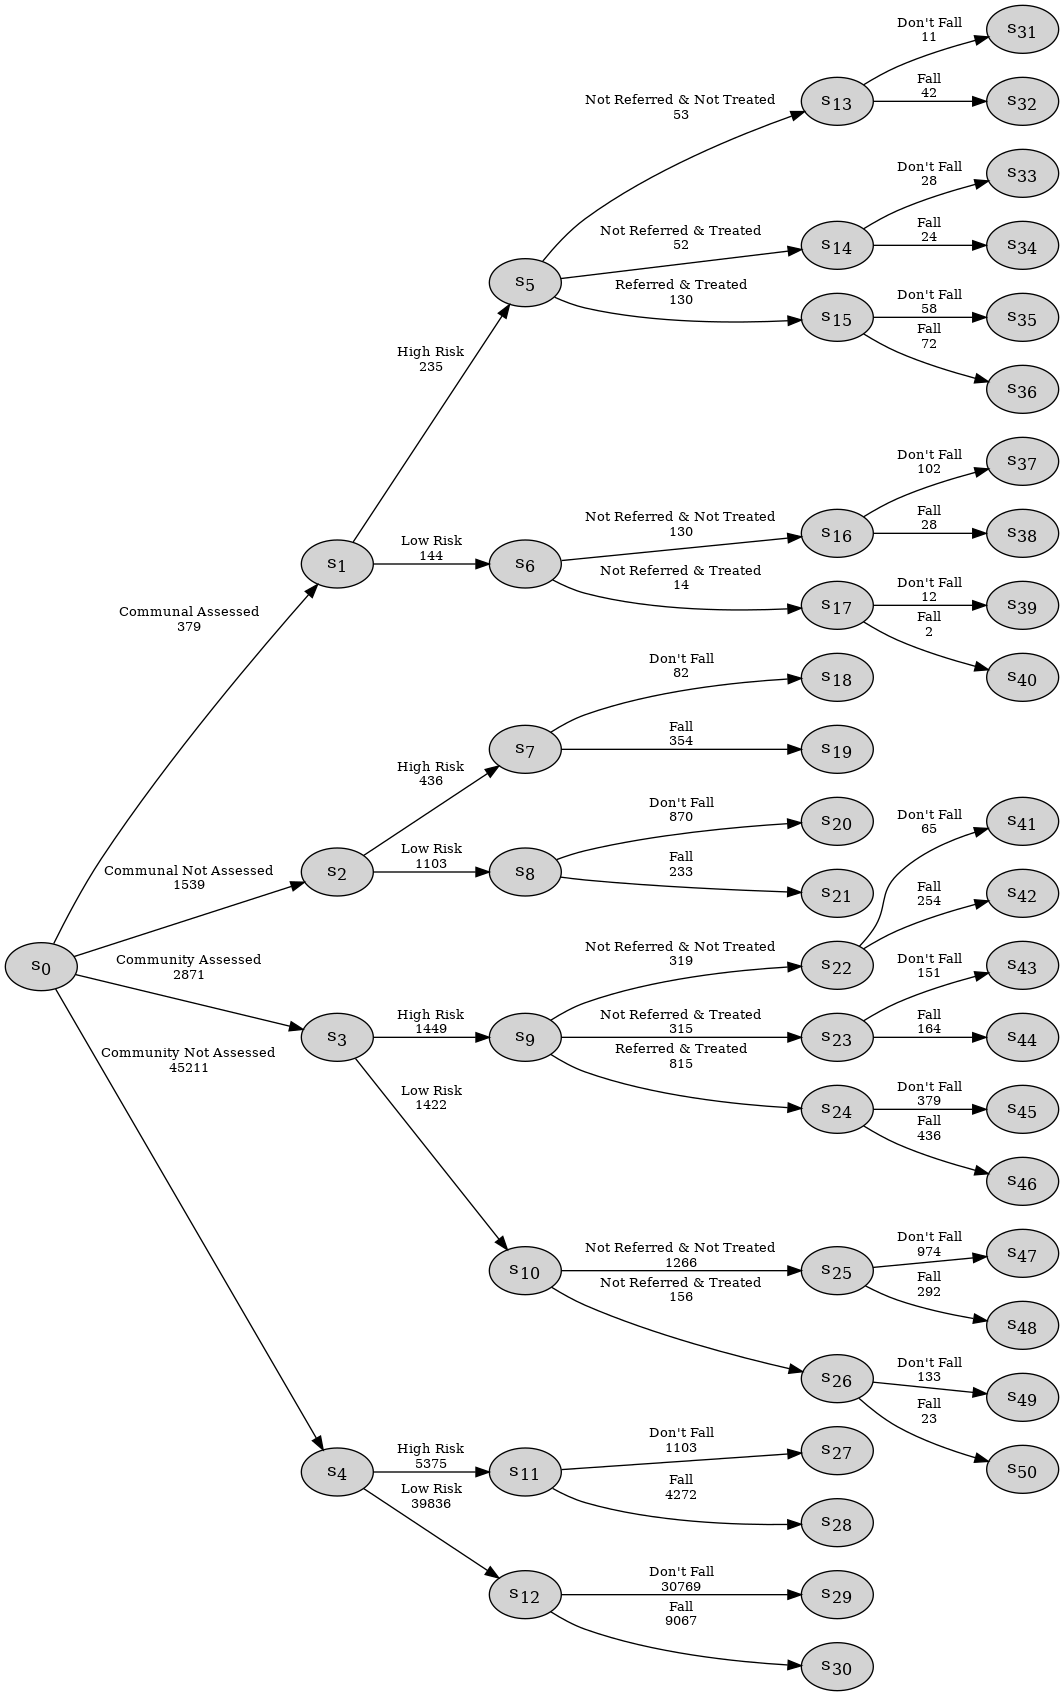

In [20]:
et = EventTree(df)
et.create_figure()

Observe that this process has structural asymmetries. None of the individuals assessed to be low risk are referred
to the falls clinic and thus, for this group, the count associated with the
$\text{`Referred \& Treated’}$ category is a structural zero:

In [43]:
df[df.Risk == "Low Risk"]['Treatment'].value_counts()

Not Referred & Not Treated    1396
Not Referred & Treated         170
Name: Treatment, dtype: int64

Moreover, for individuals who are not assessed, their responses are structurally missing for the `Treatment` variable:

In [61]:
# Missing values in each column
print(df.isna().sum())

# Missing values for Treatment are structural, 
# they are missing due to the lack of assessment:
df[df.HousingAssessment.isin([
    'Community Not Assessed', 'Communal Not Assessed'
])]['Treatment'].isna().sum()

HousingAssessment        0
Risk                     0
Treatment            46750
Fall                     0
dtype: int64


46750

In `cegpy` any paths that should logically be in the event tree description of the process but are absent from the dataset due to sampling limitations would need to be manually added by the user using the sampling zero paths argument when initialising the `EventTree` object. Further, not all missing values in the dataset will be structurally missing. 

#### How to distinguish between structual and sampling missing values?
    
e.g. Falls example: Suppose that some individuals in communal establishments who are not formally assessed but are known to be high risk were actually either `Not Referred & Treated` or `Not Referred & Not Treated` but that these observations were missing in the `falls.xlsx` dataset due to sampling limiattions. All the other blank/`NaN` cells are structurally missing.

In [70]:
idx = (df.HousingAssessment == 'Communal Not Assessed') & (df.Risk == 'High Risk')
df[idx]

,HousingAssessment,Risk,Treatment,Fall
67,Communal Not Assessed,High Risk,NaN,Fall
72,Communal Not Assessed,High Risk,NaN,Fall
95,Communal Not Assessed,High Risk,NaN,Fall
102,Communal Not Assessed,High Risk,NaN,Fall
132,Communal Not Assessed,High Risk,NaN,Fall
...,...,...,...,...
49065,Communal Not Assessed,High Risk,NaN,Fall
49087,Communal Not Assessed,High Risk,NaN,Fall
49135,Communal Not Assessed,High Risk,NaN,Don't Fall
49461,Communal Not Assessed,High Risk,NaN,Fall


To demarcate the difference between structural and sampling missing values, a user can give different labels to the structural and sampling missing values in the dataset and provide these labels to the `struct_missing_label` and `missing_label` arguments respectively when initialising the `EventTree` or `StagedTree` object.

In our example, we can replace the `NaN` values for the `Treatment` variable among the considered subset of data with a new label, e.g. `samp_miss`:

In [77]:
df.loc[idx, 'Treatment'] = 'samp_miss'

Next step is to tell the `EventTree` or `StagedTree` object about these missing value arguments as shown below. This will generate a new path along $\text{(`Communal Not Assessed', `High Risk', `missing')}$:

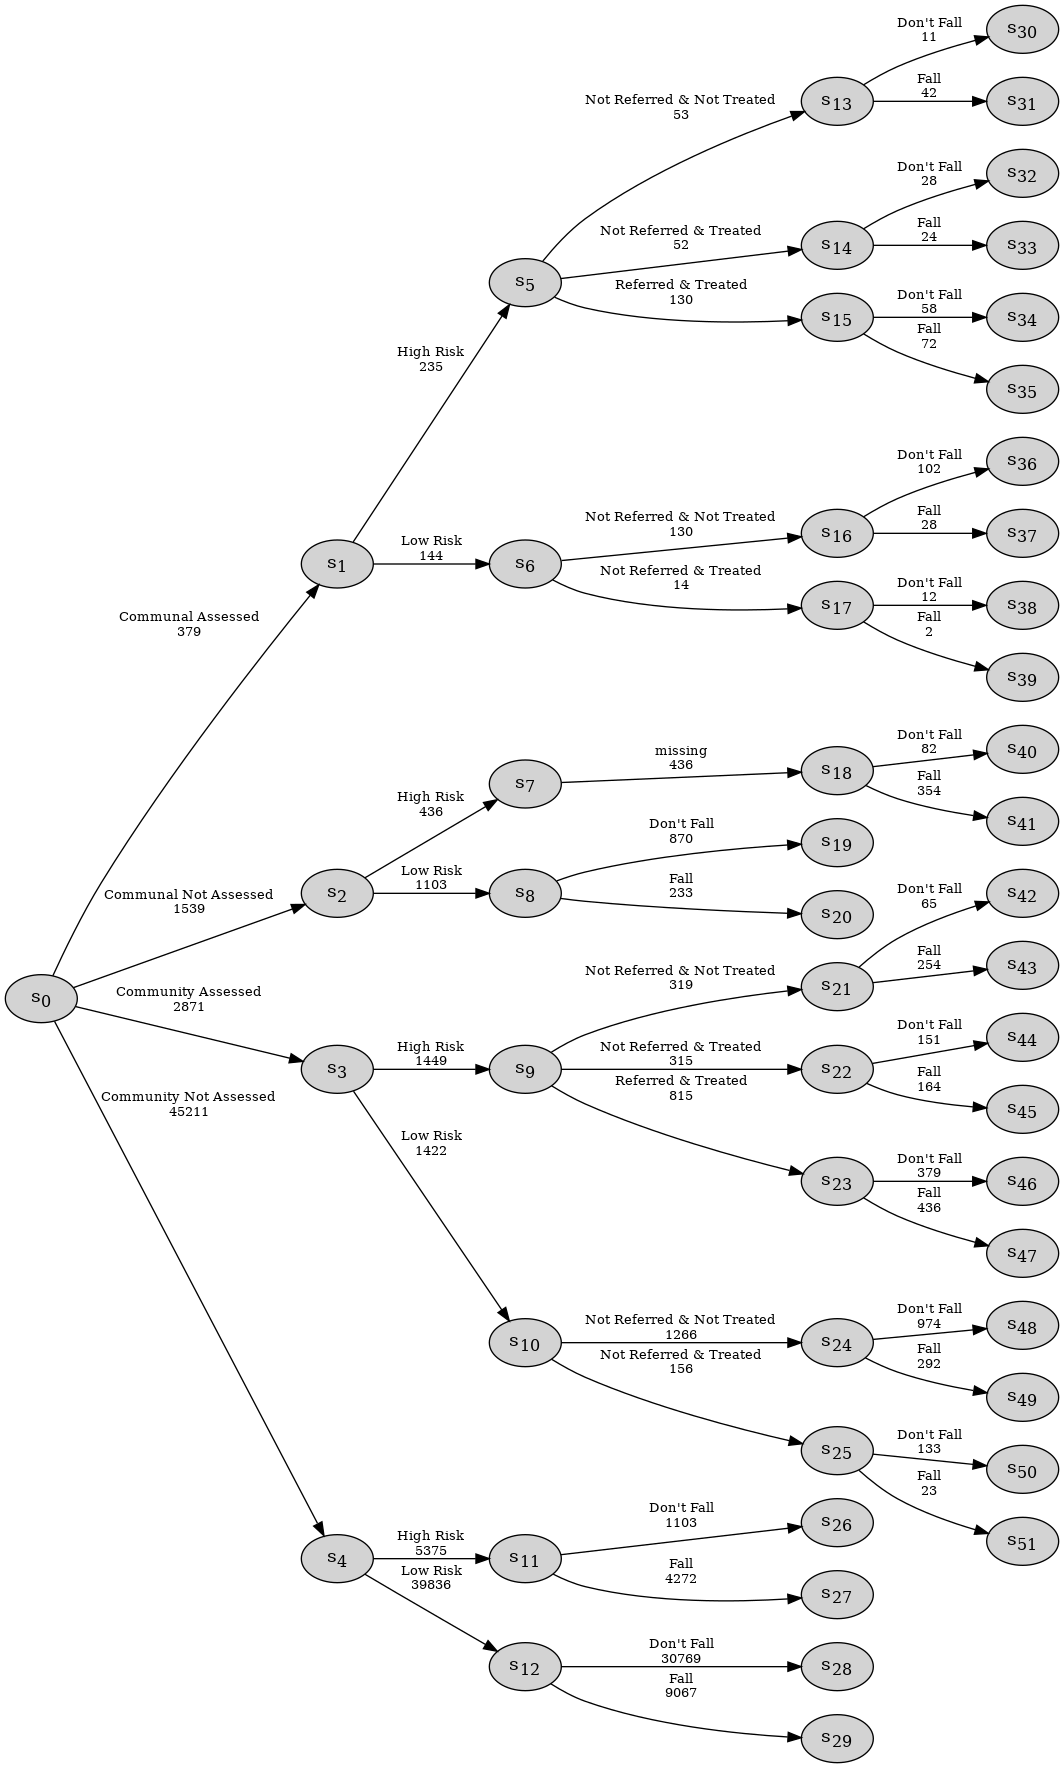

In [80]:
et2 = EventTree(df,
    missing_label='samp_miss',
)
et2.create_figure()

#### How to add sampling zeros?

e.g. Falls example: Suppose that some individuals in the community who were assessed and high risk were referred and not treated. Suppose that our observations are still the same as in the falls.xlsx dataset. Here, by design, this was allowed, but was not observed in the dataset. So we need to add this value in manually as a path $\text{(`Community Assessed', `High Risk', `Referred \& Not Treated')}$. We also need to add in the values that follow it: i.e. $\text{(`Community Assessed', `High Risk', `Referred \& Not Treated', `Fall')}$. and $\text{(`Community Assessed', `High Risk', `Referred \& Not Treated', `Don't Fall')}$.

In `cegpy` any paths that should logically be in the event tree description of the process but are absent from the dataset due to sampling limitations would need to be manually added by the user using the sampling zero paths argument when initialising the `EventTree` or `StagedTree` object. No changes need to be made to the dataset, as shown below:

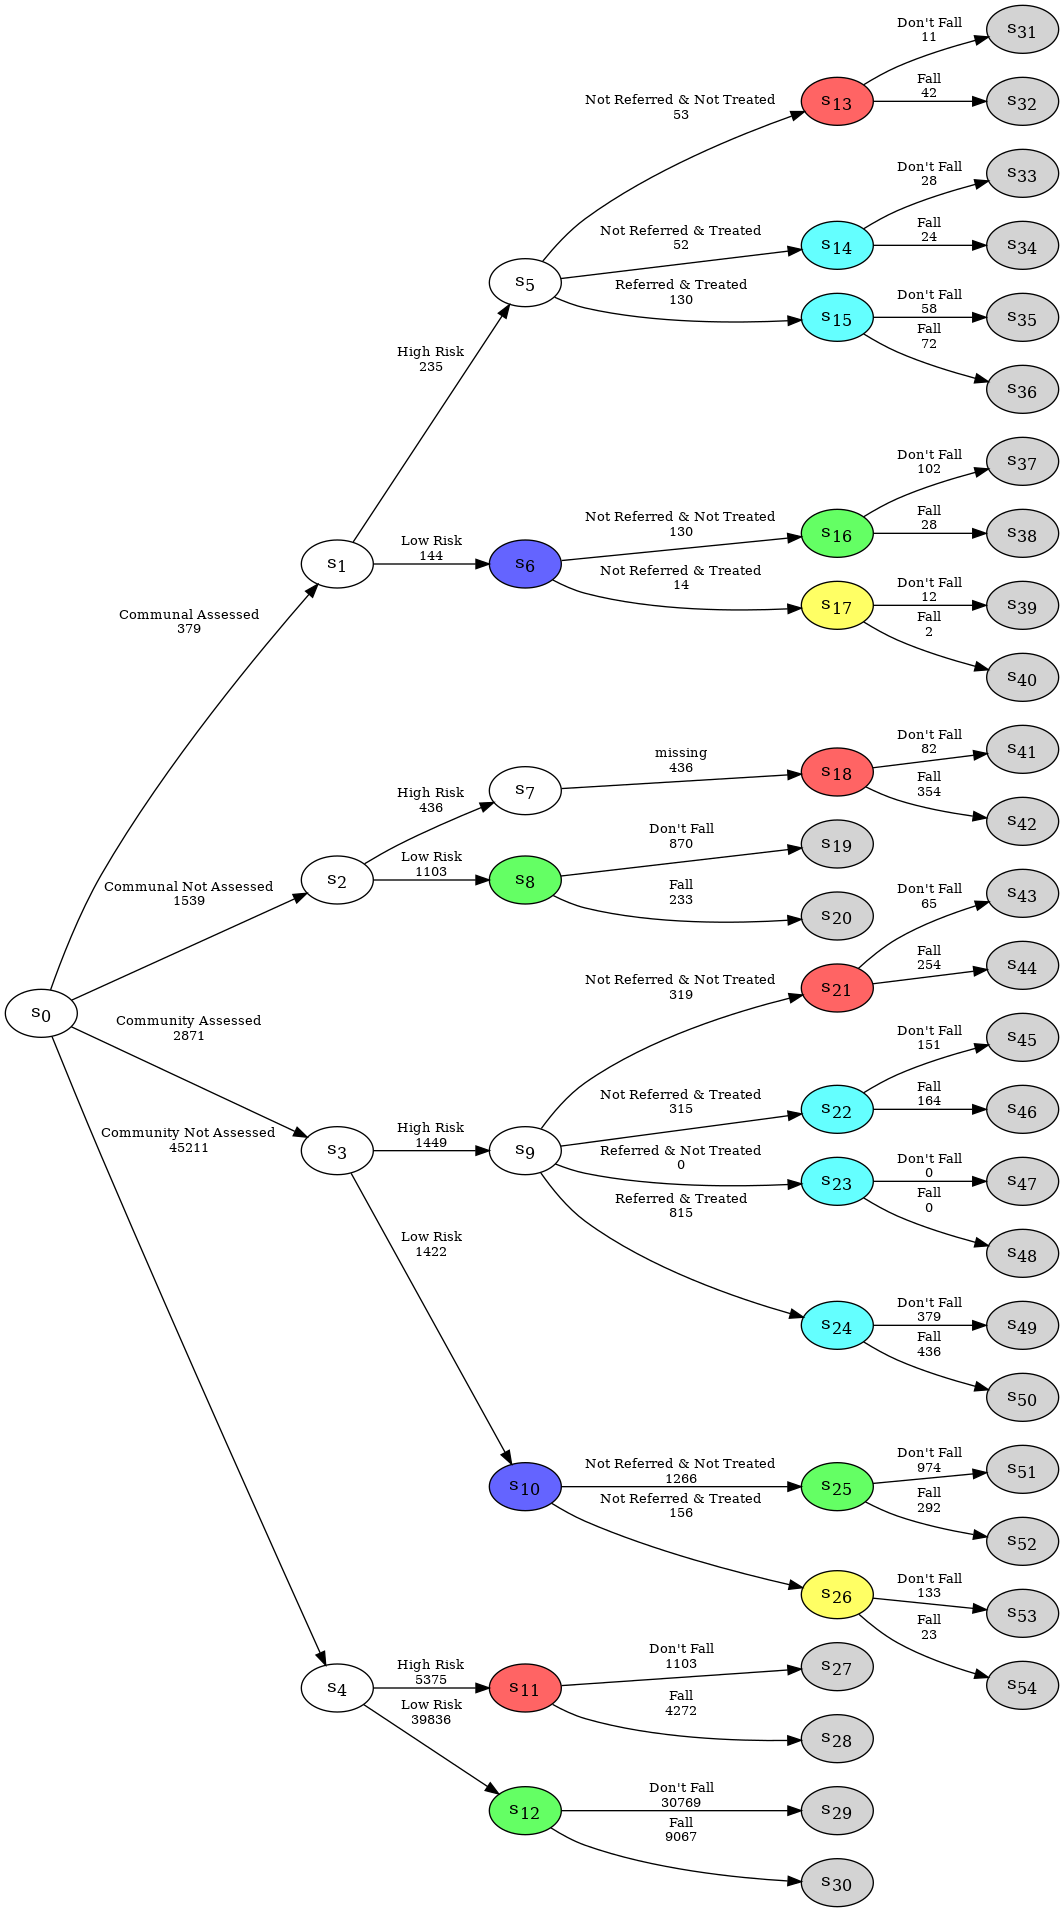

In [83]:
st2 = StagedTree(df,
    sampling_zero_paths=[
        ('Community Assessed', 'High Risk', 'Referred & Not Treated'),
        ('Community Assessed', 'High Risk', 'Referred & Not Treated', 'Fall'),
        ('Community Assessed', 'High Risk', 'Referred & Not Treated', "Don't Fall")
])
st2.calculate_AHC_transitions()
st2.create_figure()